In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import glob
import os
import peakutils
import logging
import datetime
import warnings
from lmfit.models import PseudoVoigtModel, GaussianModel
from jupyterthemes import jtplot
from matplotlib.colors import Normalize

In [2]:
from xps.xps_sw import *
from xps.xps_import import *
from xps.xps_analysis import *
from xps.xps_bg import *
from xps.xps_fits import *

jtplot.style('grade3', context='talk', grid=False, ticks=True, fscale=1.5)
logging.getLogger().setLevel(logging.CRITICAL)
warnings.filterwarnings("ignore")

In [3]:
asf = dict({'C1s' : 0.296, 'O1s' : 0.711, 'O1s_sub' : 0.711, 'N1s' : 0.477, 'Ba3d' : 7.49, 'Ba_3d_5/2' : 7.49, 'Ba_3d_3/2' : 5.20,
            'Br_3p' : 1.054, 'Cu_2p' : 5.321, 'Ba_4d': 2.35, 'Na1s' : 1.685, 'Cl_2s' : 0.37, 'Ru3d' : 4.273, 'Ru3p' : 1.53,
           'In3d' : 4.359, 'Sn3d' : 4.725, 'Cl2p' : 0.891, 'Cl2p_(2)' : 0.891, 'Cl2p_(3)' : 0.891, 'Si2p': 0.339, 'Na1s': 1.685})

asf2 = {'Ba_3d_5/2' : 25.8, 'Ba_3d_3/2': 17.9, 'Ba_4d': 5.86, 'Cl_2p': 2.28, 'Cl_2s': 1.69, }

asf3 = {'Ba_3d_5/2' : 64.3, 'Ba_3d_3/2': 49.9, 'Ba_4d': 5.86, 'Cl_2p': 2.28, 'Cl_2s': 1.50}
mfps = {'Cu2p' : 1.86, 'In3d': 3.05, 'Si2p': 3.8}

In [38]:
regss = ['O1s', 'Si2p', 'N1s', 'C1s', 'In3d', 'Ba3d5/2', 'Cl2p', 'Ru3d5/2', 'Si2s', 'Ru3p3/2', 'Na1s', 'Ir4d5/2']
asfScof = {}
for r in regss:
    asfScof.update(search_asf(r))

In [41]:
asfScof
asfScof['Ba3d'] = 5.832

# Preprocess data

In [22]:
path = '/Users/pabloherrero/sabat/xps_spectra/quartz_ANN205/'
files = glob.glob(path+'/proc/*.uxy')
# files += glob.glob(path+'*.xy')
files.sort()
files

['/Users/pabloherrero/sabat/xps_spectra/quartz_ANN205//proc/20220525_quartz_ANN205_silatrane_5e-5M_AcN.uxy',
 '/Users/pabloherrero/sabat/xps_spectra/quartz_ANN205//proc/20220526_quartz_ANN205_silatrane_5e-5M_AcN_BaCl2_30s.uxy']

In [29]:
bg = [read_processed_xp(f) for f in files]
bg[0].name

[Errno 2] No such file or directory: '/Users/pabloherrero/sabat/xps_spectra/quartz_ANN205//proc/20220525_quartz_ANN205_silatrane_5e-5M_AcN.uxy.ft', returning empty fit dict
[Errno 2] No such file or directory: '/Users/pabloherrero/sabat/xps_spectra/quartz_ANN205//proc/20220526_quartz_ANN205_silatrane_5e-5M_AcN_BaCl2_30s.uxy.ft', returning empty fit dict


'quartz_ANN205_silatrane_5e-5M_AcN'

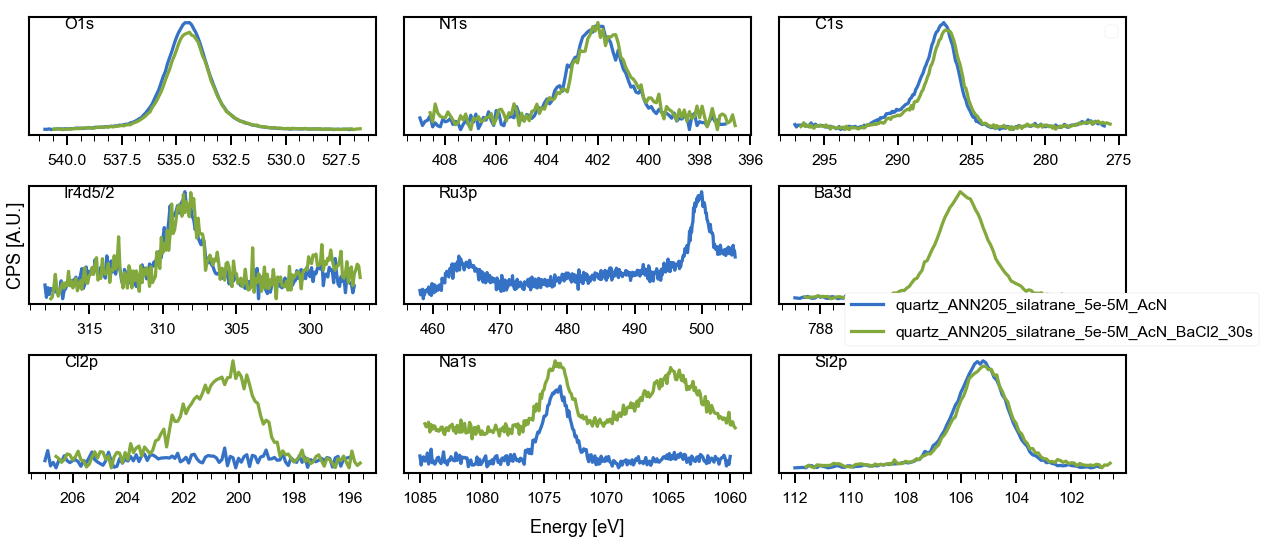

In [51]:
regions = ['O1s', 'N1s', 'C1s', 'Ir4d5/2', 'Ru3p', 'Ba3d', 'Cl2p', 'Na1s', 'Si2p']
plot_xp_regions(bg, regions, ncols=3);

In [31]:
bg[0].area

{'C1s': 4772.960645435031,
 'N1s': 503.1612182068025,
 'O1s': 24885.64109578107,
 'Si2p': 7551.984650762766,
 'Ba3d': 42.94815699429942,
 'Cl2p': 168.63776655442362}

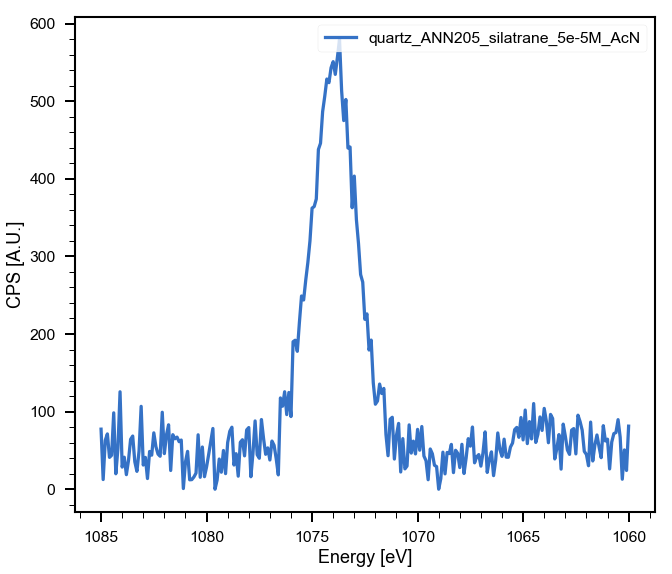

In [86]:
plot_region(bg[0], 'Na1s')


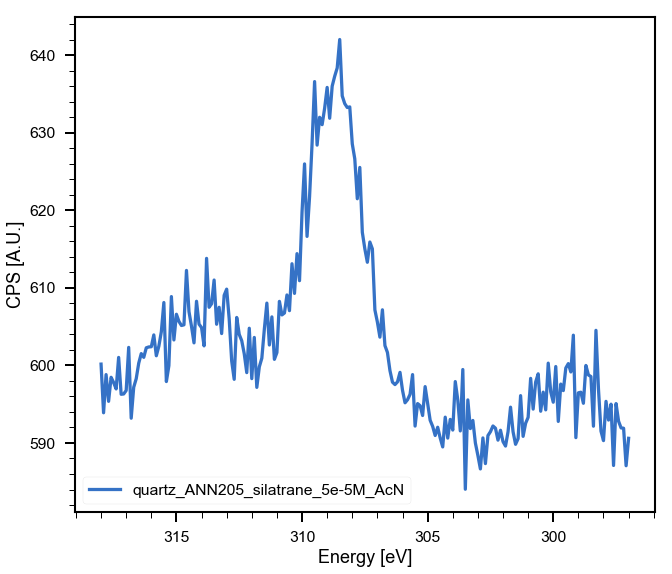

In [33]:
plot_region(bg[0], 'Ir4d5/2')

KeyError in 'Ru3p'


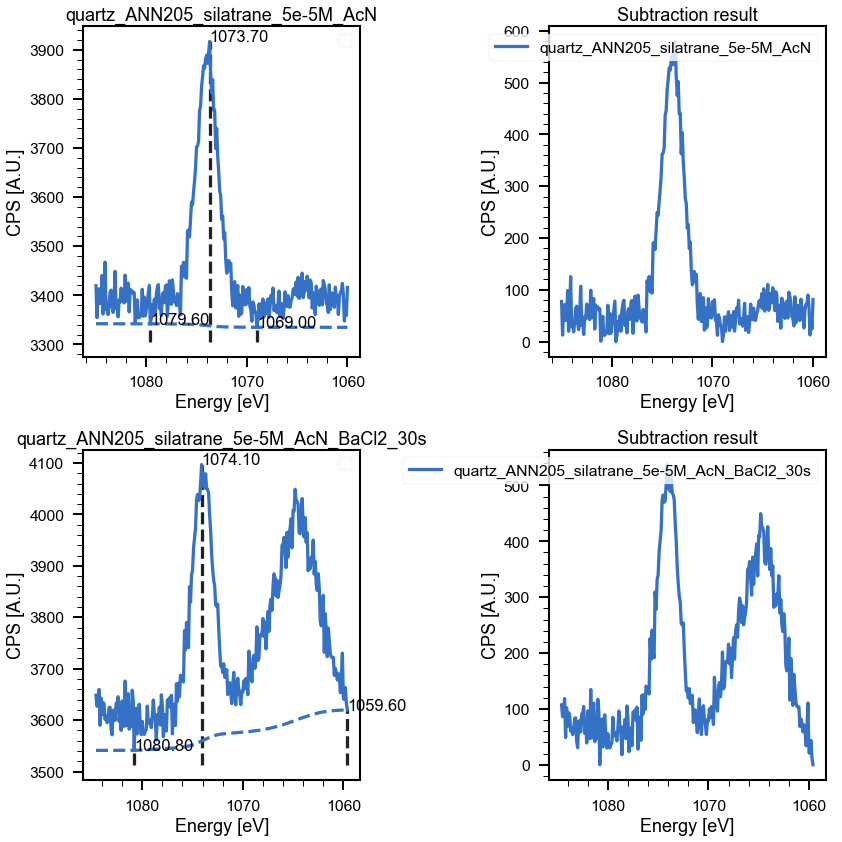

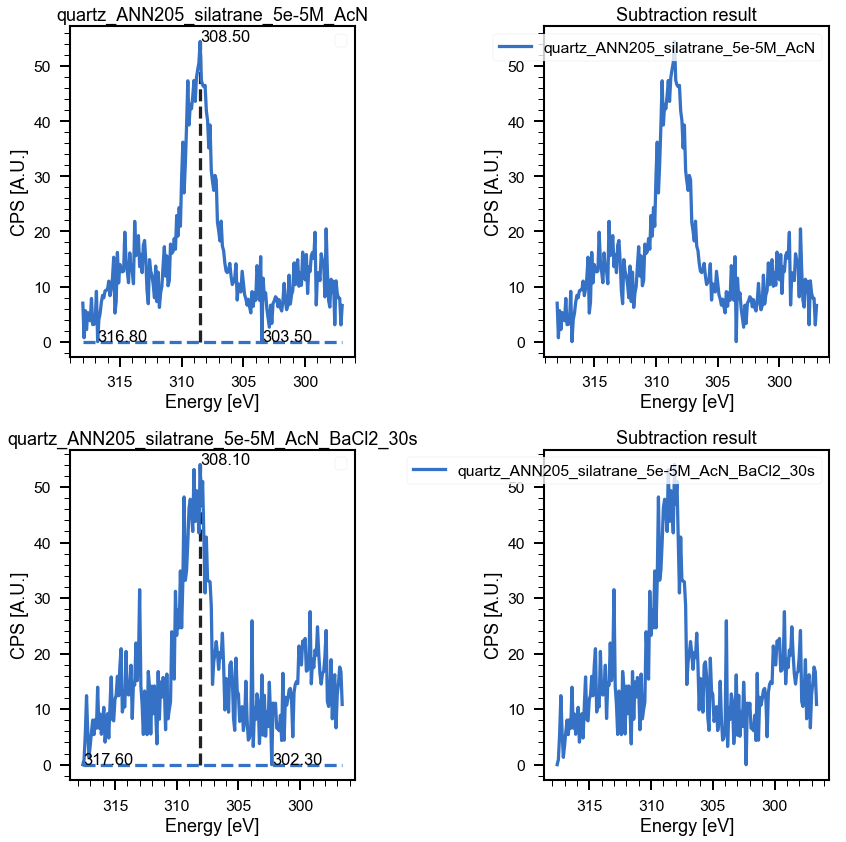

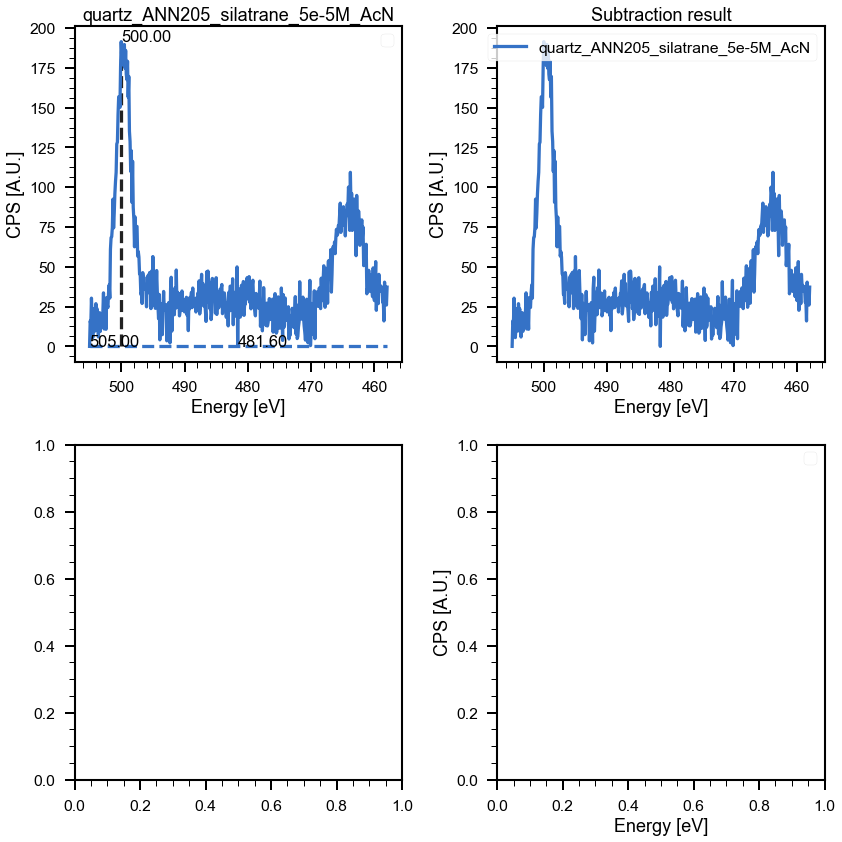

In [85]:
bg = region_bg_subtract(bg, 'Na1s')
bg = region_bg_subtract(bg, 'Ir4d5/2')
bg = region_bg_subtract(bg, 'Ru3p')

# Stoichiometry

'Ru3p' , asf missing, returning raw area
'Ru3p' region does not exist in quartz_ANN205_silatrane_5e-5M_AcN_BaCl2_30s


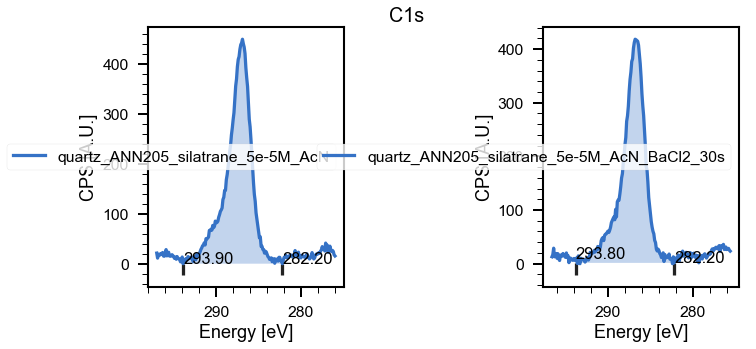

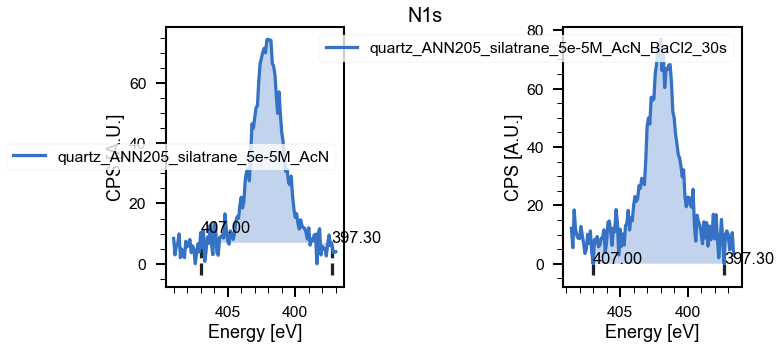

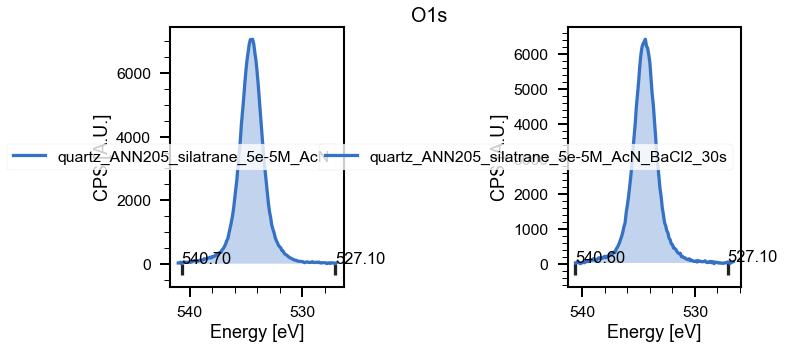

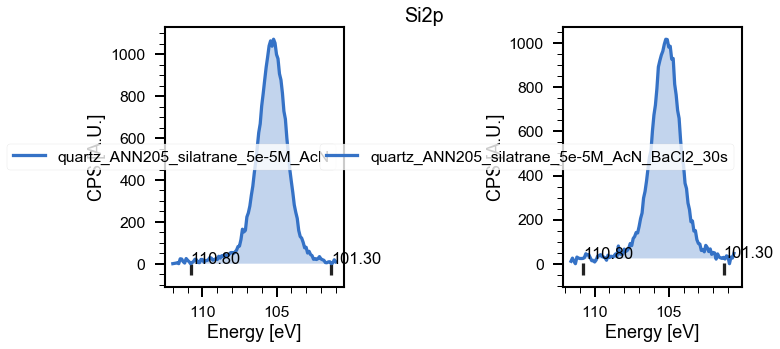

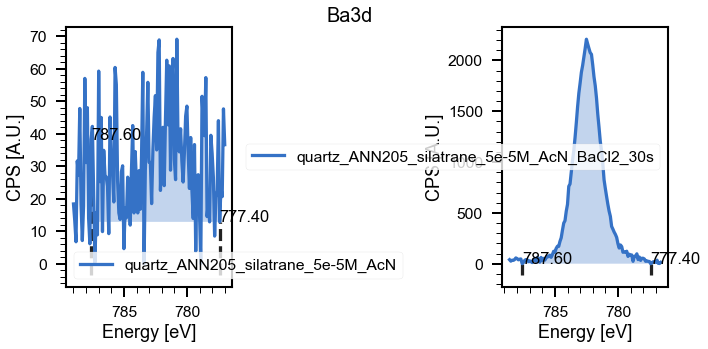

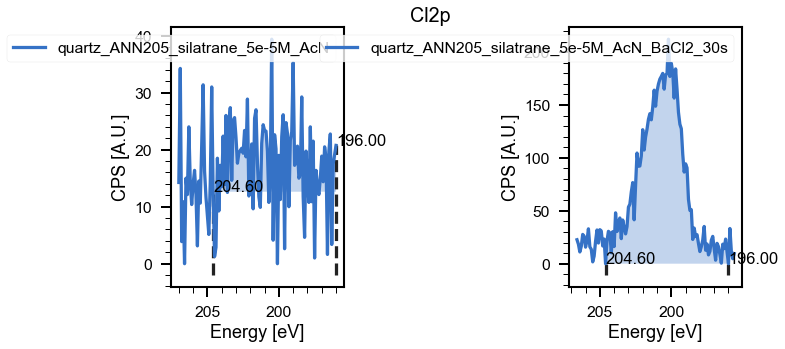

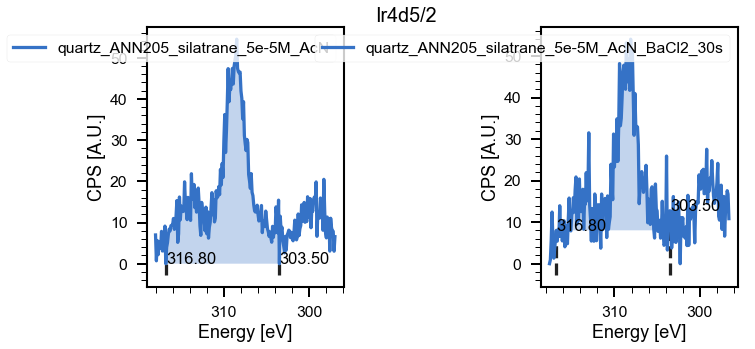

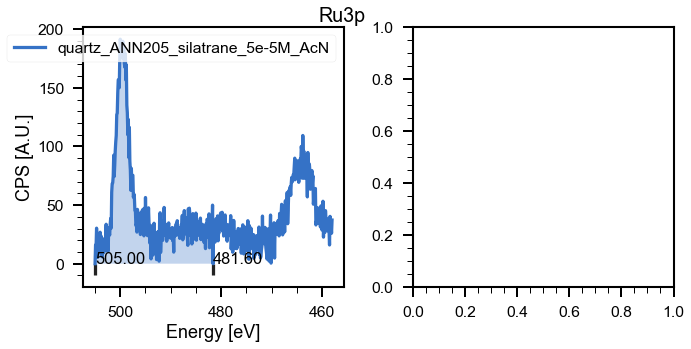

In [82]:
regs = ['C1s', 'N1s', 'O1s', 'Si2p', 'Ba3d', 'Cl2p', 'Ir4d5/2', 'Ru3p']

for r in regs:
    integrateRegions(bg, r, asf=asfScof)

[1810.0680874137513, 1834.9165623529323]

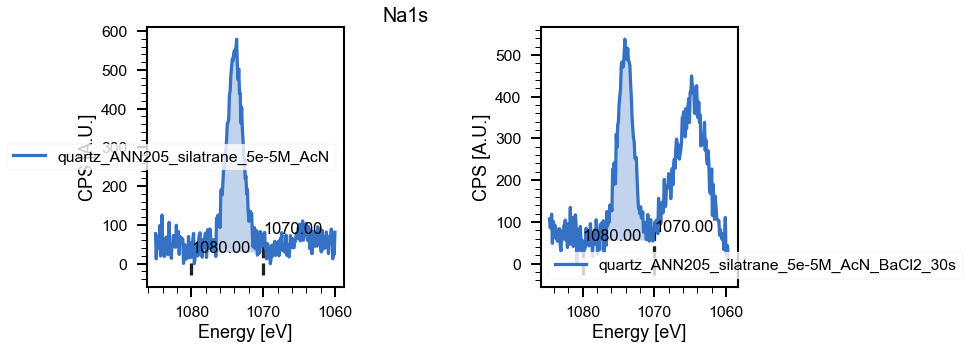

In [87]:
integrateRegions(bg, 'Na1s', asf=asfScof, edw=1070, eup=1080)

In [88]:
bg[0].area

{'C1s': 6258.687835146049,
 'N1s': 590.6861121138759,
 'O1s': 26751.894310107335,
 'Si2p': 13881.693988954714,
 'Ba3d': 55.15804113293941,
 'Cl2p': 291.3064277899178,
 'Na1s': 941.1504257327368,
 'Ir4d5/2': 99.92842098470754,
 'G2': 147.67152802846897,
 'ANN205': 84.38373030198227}

In [75]:
a = {'C1s': 12+6*3+5*4+2*4, 'N1s': 7, 'Si2p': 2, 'O1s': 13, 'Ir4d5/2': 1,
     'Ba3d': 1e-10, 'Cl2p': 1e-10, 'Na1s': 1e-10, 'Ru3p': 1e-10}
ann250sl = XPS_experiment(name='Sto. ANN205-SL', area=a)

for xp in bg:
    xp.area['ANN205'] = xp.area['N1s'] / 7


In [77]:
ann250sl

XPS_experiment(path=None, delimiters=None, name='Sto. ANN205-SL', label=None, date=None, other_meta=None, dfx=None, area={'C1s': 58, 'N1s': 7, 'Si2p': 2, 'O1s': 13, 'Ir4d5/2': 1, 'Ba3d': 1e-10, 'Cl2p': 1e-10, 'Na1s': 1e-10, 'Ru3p': 1e-10}, fit=None, color=None, ls=None)

In [78]:
num = ['C1s', 'N1s', 'C1s']
denom = ['N1s', 'Ir4d5/2', 'Ir4d5/2']
display_stoichiometry(bg+[ann250sl], num, denom)

In [89]:
num = ['Ba3d','Ba3d', 'Na1s', 'Ru3p', 'Ba3d', 'Na1s']
denom = ['Cl2p', 'ANN205', 'ANN205', 'ANN205', 'Ir4d5/2', 'Ir4d5/2']
display_stoichiometry(bg+[ann250sl], num, denom)

Ru3p  or  ANN205  was not measured
Ba3d  or  ANN205  was not measured
Na1s  or  ANN205  was not measured
Ru3p  or  ANN205  was not measured


## Coverage

In [91]:
files

['/Users/pabloherrero/sabat/xps_spectra/quartz_ANN205//proc/20220525_quartz_ANN205_silatrane_5e-5M_AcN.uxy',
 '/Users/pabloherrero/sabat/xps_spectra/quartz_ANN205//proc/20220526_quartz_ANN205_silatrane_5e-5M_AcN_BaCl2_30s.uxy']

In [94]:
fclean = '/Users/pabloherrero/sabat/xps_spectra/quartz_FBIG2/2021_12_15_quartz_4ML/proc/20211215_Quartz_clean.uxy'
xpclean = read_processed_xp(fclean)

[Errno 2] No such file or directory: '/Users/pabloherrero/sabat/xps_spectra/quartz_FBIG2/2021_12_15_quartz_4ML/proc/20211215_Quartz_clean.uxy.ft', returning empty fit dict


[4065.775918269717, 2521.005848606208, 2518.248637145166]

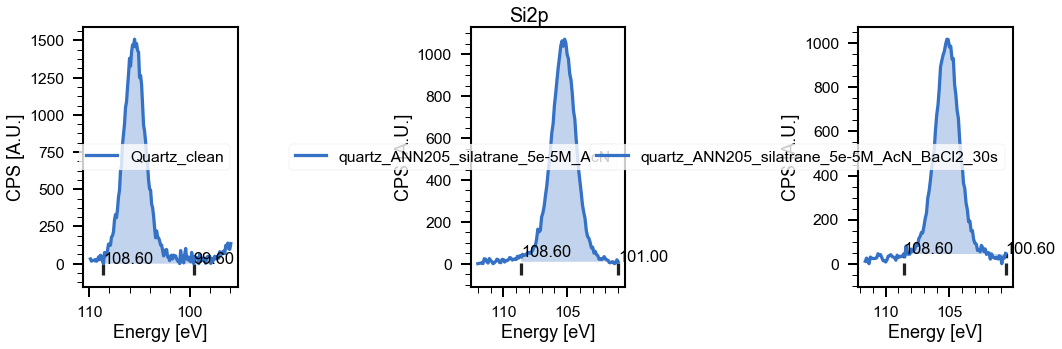

In [100]:
integrateRegions([xpclean]+bg, 'Si2p', asf=asfScof)

In [103]:
n_layers(xpf=bg[0], xp0=xpclean, r_ml=1.4, region= 'Si2p', mfp= 3.55, takeoff=10) 

(1.1935240760361607, 0.027185600630509465)

# Main plots...

In [ ]:
region = 'Ba3d'
for xp in bg[3:]:
    plot_region(xp, region, lb = xp.name.replace('quartz_FBIG2_silatrane_', '').replace('_15sec', '').replace('_15s', ''))
    
plt.gca().invert_xaxis()
plt.legend(fontsize=22, loc='best')

In [ ]:
region = 'C1s'
for xp in norm[:2]:
    plot_region(xp, region, lb = xp.name.replace('quartz_FBIG2_silatrane_', ''))
    
plt.gca().set(xlim=(297.5, 281))
plt.legend(fontsize=22, loc='best')

In [ ]:
region = 'C1s'
cols = ['r', 'm']
for i,xp in enumerate(norm[2:4]):
    xp.color = cols[i]
    plot_region(xp, region, lb = xp.name.replace('quartz_FBIG2_silatrane_', ''))
    
plt.gca().set(xlim=(297.5, 285))
plt.legend(fontsize=22, loc='best')

In [ ]:
region = 'C1s'
cols = ['r', 'm', 'y']
for i,xp in enumerate(norm[2:]):
    xp.color = cols[i]
    plot_region(xp, region, lb = xp.name.replace('quartz_FBIG2_silatrane_', ''))
    
# plt.gca().set(xlim=(297.5, 285))
plt.legend(fontsize=22, loc='best')

## Other regions

In [ ]:
plot_region(bg[5], 'Na1s')
plt.gca().get_legend().remove()

In [ ]:
plot_region(bg[5], 'Ru3p')
plt.gca().get_legend().remove()

In [ ]:
fileovw = '/Users/pabloherrero/sabat/xps_spectra/quartz_FBIG2/2022_04_26_quartz_G2SL_BOLD078_A2/20220426_quartz_FBIG2_silatrane_BOLD078A2.xy'

ovw = xps_data_import(fileovw)

In [ ]:
fileru = '/Users/pabloherrero/sabat/xps_spectra/ITO_Ru-Ir/2022_02_03_qITO_RuPTES_BOLD038A/20220203_qITO_PTES_Ru.xy'

ru = xps_data_import(fileru)
align_dfx(ru, shift=1.4, inplace=True)

In [ ]:
plt.rcParams['lines.linewidth'] = 1

plt.figure(figsize=(16, 8))
plot_region(ovw, 'overview')
plt.rcParams['lines.linewidth'] = 2.08


In [ ]:
plt.rcParams['lines.linewidth'] = 1

plt.figure(figsize=(8, 8))
plot_region(ovw, 'overview')
plt.gca().set(xlim=(1080, 1070), ylim=(3e3, 3.6e3))
plt.rcParams['lines.linewidth'] = 2.08


In [ ]:
plt.rcParams['lines.linewidth'] = 1

plt.figure(figsize=(8, 8))
plot_region(ovw, 'overview', offset=300)
plot_region(ru, 'C1s')

plt.gca().set(xlim=(294, 272), ylim=(0.9e3, 2.2e3))
plt.rcParams['lines.linewidth'] = 2.08


In [ ]:
plt.rcParams['lines.linewidth'] = 1

plt.figure(figsize=(12, 8))
plot_region(ovw, 'overview')
# plot_region(experiments[5], 'N1s')

plt.gca().set(xlim=(507, 396), ylim=(0.7e3, 1e3))
plt.rcParams['lines.linewidth'] = 2.08
